In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the last layer to match MNIST classes (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Set the model to training mode and use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\4311698\.conda\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\4311698\.conda\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\4311698/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.5MB/s]


In [3]:
# Transform images to 224x224 and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [01:34<00:00, 105kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 185kB/s]
100%|██████████| 1.65M/1.65M [00:15<00:00, 106kB/s] 
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [4]:
# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler to adjust the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [5]:
# Fine-tune the model
num_epochs = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler after each epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

print('Fine-tuning complete!')

Epoch [1/1], Loss: 0.0682
Fine-tuning complete!


In [6]:
# Save the fine-tuned model
torch.save(model.state_dict(), 'finetuned_resnet18_mnist.pt')
print('Model saved!')

Model saved!


In [7]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the fine-tuned model on the test images: {100 * correct / total:.2f}%')

Accuracy of the fine-tuned model on the test images: 98.94%


In [8]:
# Load the model for inference
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('finetuned_resnet18_mnist.pt'))
model.eval()
model = model.to(device)

# Make a prediction on a single image from the test set
test_image, _ = testset[0]  # Get the first image from the test set
test_image = test_image.unsqueeze(0).to(device)  # Add a batch dimension and move to device

output = model(test_image)
_, predicted = torch.max(output, 1)

print('Predicted label:', predicted.item())

Predicted label: 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].



Predicted label: 7


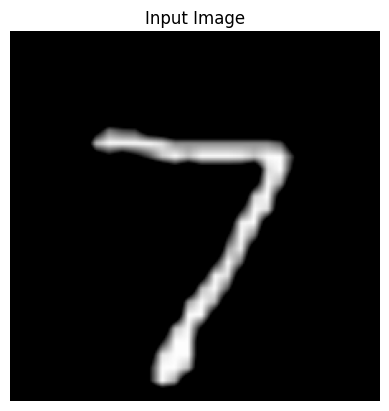

In [9]:
# Load the model for inference
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('finetuned_resnet18_mnist.pt', map_location=device))
model.eval()
model = model.to(device)

# Get a single image from the test set
test_image, _ = testset[0]  # Get the first image from the test set

# Display the image
plt.imshow(test_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # Convert tensor to NumPy and plot
plt.axis('off')
plt.title("Input Image")

# Preprocess and predict
test_image = test_image.unsqueeze(0).to(device)  # Add a batch dimension and move to device
output = model(test_image)
_, predicted = torch.max(output, 1)

print('\nPredicted label:', predicted.item())

# Show the image
plt.show()